In [1]:
# Packages
import numpy as np
import pandas as pd
from statsmodels.sandbox.regression.gmm import IV2SLS
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pandas.api.types import CategoricalDtype
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression
import plotly.express as px

#import dataframe_image as dfi
import jinja2
from statsmodels.distributions.empirical_distribution import ECDF

# Normality tests
from scipy.stats import jarque_bera, shapiro, anderson, cramervonmises,t,chi2
from scipy.stats import norm, zscore
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.stattools import omni_normtest # Doornik-Hansen

## Question 5

In [2]:
# import data and preview
df = pd.read_csv('assignmentweakinstruments.csv')
df.head() 

,age,age2,ed,exper,exper2,nearc2,nearc4,nearc4a,nearc4b,race,smsa,south,wage
0,29,841,7,16,256,0,0,0,0.001220,1,1,0,6.306275
1,27,729,12,9,81,0,0,0,-0.002496,0,1,0,6.175867
2,34,1156,12,16,256,0,0,0,-0.000917,0,1,0,6.580639
3,27,729,11,10,100,1,1,1,-0.001483,0,1,0,5.521461
4,34,1156,12,16,256,1,1,1,0.000939,0,1,0,6.591674


### a)

In [3]:
## a) Using only nearc2 as an instrument, construct the 95% conÖdence set for the return on education using the 2SLS t-statistic and the AR statistic.

## first create matrix w
df['constant'] = 1

# Select the required columns and combine them into a matrix
columns_to_include = ['exper', 'exper2', 'south', 'smsa', 'race', 'constant']
w = df[columns_to_include].values

### regress y, x, z on W then obtain M_wy etc.
def partial_out(variable, W):
    """Regress variable on W and return residuals."""
    reg = LinearRegression(fit_intercept=False).fit(W, variable)
    residuals = variable - W @ reg.coef_.T
    return residuals

y=partial_out(df['wage'],w)
X=partial_out(df['ed'],w)
Z=partial_out(df['nearc2'],w)

alpha = 0.05
test_2sls = IV2SLS(y, X, Z).fit()
print(f'Confidence interval using 2SLS statistic: {test_2sls.conf_int(alpha)}')

Confidence interval using 2SLS statistic:            0         1
ed -0.043482  0.743009


In [4]:
## a) Using only nearc2 as an instrument, construct the 95% conÖdence set for the return on education using the 2SLS t-statistic and the AR statistic.

## first create matrix w
df['constant'] = 1

# Select the required columns and combine them into a matrix
columns_to_include = ['exper', 'exper2', 'south', 'smsa', 'race', 'constant']
w = df[columns_to_include].values

### regress y, x, z on W then obtain M_wy etc.
def partial_out(variable, W):
    """Regress variable on W and return residuals."""
    reg = LinearRegression(fit_intercept=False).fit(W, variable)
    hat=W @ reg.coef_.T
    residuals = variable - W @ reg.coef_.T
    return residuals,hat

y=partial_out(df['wage'],w)[0]
x=partial_out(df['ed'],w)[0]
z=partial_out(df['nearc2'],w)[0]


### 2sls
def two_sls(y, x, z):

    n = len(y)

    # Estimate pi_hat
    pi_hat = np.sum(x*z)/np.sum(z**2)

    # Compute residuals from 1st stage regression
    x_hat = pi_hat*z
    u_hat = x - x_hat

    # Estimate beta_hat
    beta_hat = np.sum(x_hat*y)/np.sum(x_hat**2)

    # Compute residuals from 2nd stage regression
    eps_hat = y - beta_hat*x

    # Compute standard error of beta_hat
    s_2 = np.sum(eps_hat**2) / (n - 1)  # residual variance; (n-1) because we only have 1 regressor and no intercept
    se_beta_hat = np.sqrt (s_2 / np.sum(x_hat**2))  # standard error of 2SLS estimator
    # np.sqrt (s_2 * np.sum(z*z) / np.sum((z*x)**2)) this formula is equivalent, but gives numerical instability

    # t statistic
    t_2sls=beta_hat/se_beta_hat

    #CI
    CI_upper=beta_hat-se_beta_hat*t.ppf(0.05 / 2, n-1)
    CI_lower=beta_hat-se_beta_hat*t.ppf(1 - 0.05 / 2, n-1)

    # Return fitted residuals
    return beta_hat, pi_hat, eps_hat, u_hat, se_beta_hat,t_2sls,CI_lower,CI_upper

t_2sls=two_sls(y,x,z)[5]
t_CI_upper=two_sls(y,x,z)[-1]
t_CI_lower=two_sls(y,x,z)[-2]

print(f"The 95% confidence interval for 2SLS t-statistic is ({t_CI_lower},{t_CI_upper})")
print(f"The t-statistic for the 2SLS estimater is {t_2sls}")



The 95% confidence interval for 2SLS t-statistic is (-0.04348185177658398,0.7430090199491135)
The t-statistic for the 2SLS estimater is 1.7439487536638936


In [5]:
### anderson-rubin test

def AR_stat (X,Y,Z,B_0):
    N = Z.shape[0]
    k = Z.shape[1]
    
    numerator = (y - X*B_0).T @ (Z@np.linalg.inv(Z.T@Z)@Z.T) @ (y - X*B_0).T / k
    denominator = (y - X*B_0).T @ (np.eye(N) - Z@np.linalg.inv(Z.T@Z)@Z.T) @ (y - X*B_0).T / (N - k)
    AR_statistic=numerator / denominator
    
    return AR_statistic

beta0=np.linspace(-3,3,10000) # possible values for beta

AR=[]
for beta in beta0:
    z=np.array(z).reshape(-1,1)
    AR.append(AR_stat(x, y, z, beta))
print(f"The critical value for 2SLS AR-statistic is {chi2.ppf(0.95,1)}")


KeyboardInterrupt: 

In [6]:
### anderson-rubin test more efficient calculation

def AR_stat (X,Y,Z,B_0):
    N = Z.shape[0]
    k = Z.shape[1]
    
    w=y - X*B_0
    numerator = partial_out(w,Z)[1].T@partial_out(w,Z)[1] / k
    denominator =partial_out(w,Z)[0].T@partial_out(w,Z)[0]  / (N - k)
    AR_statistic=numerator / denominator
    
    return AR_statistic

beta0=np.linspace(-10,10,100000) # possible values for beta

AR=[]
for beta in beta0:
    z=np.array(z).reshape(-1,1)
    AR.append(AR_stat(x, y, z, beta))
print(f"The critical value for 2SLS AR-statistic is {chi2.ppf(0.95,1)}")


The critical value for 2SLS AR-statistic is 3.8414588206941205


In [7]:
critical_value=chi2.ppf(0.95,1)
beta_lower=beta0[AR>chi2.ppf(0.95,1)][0]
beta_upper=beta0[AR>chi2.ppf(0.95,1)][-1]
print(f"The 95% confidence interval for AR-statistic is (-infty,{beta_lower}),{beta_upper},+infty)")


The 95% confidence interval for AR-statistic is (-infty,-1.4763147631476308),0.11910119101191086,+infty)


In [10]:
## first stage F-statisitc
def two_sls_first_stage_F_statistic(y, x, z):

    n = len(y)

    # Estimate pi_hat
    pi_hat = np.sum(x*z)/np.sum(z**2)

    # Compute residuals from 1st stage regression
    x_hat = pi_hat*z
    u_hat = x - x_hat

    # Compute standard error of pi_hat
    s_2 = np.sum(u_hat**2) / (n - 1)  # residual variance; (n-1) because we only have 1 regressor and no intercept
    se_beta_hat = np.sqrt (s_2 / np.sum(z**2))  # standard error of 2SLS estimator

    # t statistic
    t_statistic=pi_hat/se_beta_hat
    # F statistic when R=1
    f_statistic=t_statistic**2

    # Return fitted residuals
    return f_statistic

F_stat=two_sls_first_stage_F_statistic(y,X,Z)
    
print(f'The first stage F-statistic is given by: {F_stat:.3f}')
print(f'The AR-statistic is given by: {AR_stat(X,y,z,100000):.3f} when beta equals to 100000')

print(f'The AR-statistic is given by: {AR_stat(X,y,z,-100000):.3f} when beta equals to -100000')


The first stage F-statistic is given by: 2.810
The AR-statistic is given by: 2.810 when beta equals to 100000
The AR-statistic is given by: 2.810 when beta equals to -100000


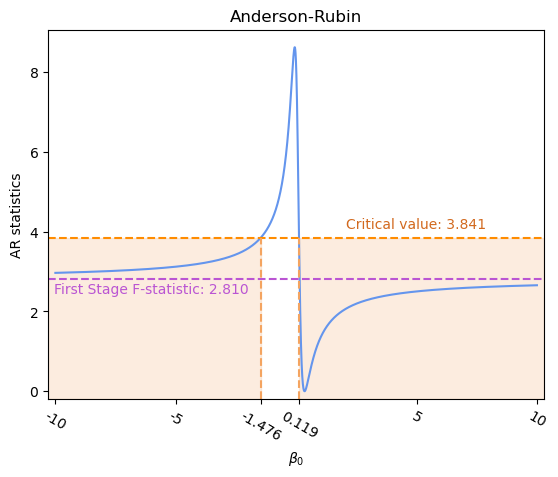

In [13]:
fig, ax = plt.subplots()  
y_value = 3.8414588206941205
ax.plot(beta0,AR,color='cornflowerblue')  # Plot some data on the Axes.
ax.axhline(y=3.8414588206941205, color='darkorange', linestyle='--', label='AR = 3.8415')  # Add a horizontal line
ax.axhline(y=F_stat,color='mediumorchid', linestyle='--')
ax.annotate(f'First Stage F-statistic: {F_stat:.3f}', 
            xy=(-6, F_stat-0.6), xycoords='data',  # Adjust `x` as needed for placement
            xytext=(0, 5), textcoords='offset points',  # Offset slightly above the line
            ha='center', va='bottom', color='mediumorchid')
ax.vlines(x=[beta_lower,beta_upper],ymin=-0.2, ymax=3.841458820694120, color='sandybrown', linestyle='--', label=f'Lower bound = {beta_lower:.2f}')
# ax.vlines(x=beta_upper, ymin=0, ymax=3.841458820694120,color='green', linestyle='--', label=f'Upper bound = {beta_upper:.2f}')
# add the critical value annotation on the RHS of the y-axis
ax.annotate(f'Critical value: {y_value:.3f}', 
            xy=(5, y_value), xycoords='data',  # Adjust `x` as needed for placement
            xytext=(0, 5), textcoords='offset points',  # Offset slightly above the line
            ha='center', va='bottom', color='chocolate')

ax.set_ylim(-0.2, None)
ax.set_xlim(-10.3, 10.3)

# add the shaded area (CI)
ax.fill_between((-10.3,beta_lower ), -0.2,y_value, color='sandybrown', alpha=0.2)
ax.fill_between((beta_upper,10.3 ), -0.2,y_value, color='sandybrown', alpha=0.2)
# add x-tick and xtick lable 
ax.set_xticks([beta_lower,beta_upper,5,-5,10,-10])  # Add beta_lower to the ticks
ax.set_xticklabels([f'{beta_lower:.3f}',f'{beta_upper:.3f}',5,-5,10,-10],color="black",rotation=-30)
# Move the label for 0 above the x-axis
# ax.annotate('0', 
#             xy=(0, -0.2), xycoords='data',  # Set the x-coordinate at 0
#             xytext=(0, 10), textcoords='offset points',  # Offset above the x-axis
#             ha='center', va='bottom', color='black') 
ax.set_title("Anderson-Rubin")
ax.set_xlabel(r"$\beta_0$")
ax.set_ylabel("AR statistics")
plt.savefig('anderson_rubin_plot.png', dpi=800, bbox_inches='tight')  # Export as a PNG file with high resolution

plt.show()  

### c)

In [197]:
## first stage F-statisitc
def two_sls_first_stage_F_statistic(y, x, z):

    n = len(y)

    # Estimate pi_hat
    pi_hat = np.sum(x*z)/np.sum(z**2)

    # Compute residuals from 1st stage regression
    x_hat = pi_hat*z
    u_hat = x - x_hat

    # Compute standard error of pi_hat
    s_2 = np.sum(u_hat**2) / (n - 1)  # residual variance; (n-1) because we only have 1 regressor and no intercept
    se_beta_hat = np.sqrt (s_2 / np.sum(z**2))  # standard error of 2SLS estimator

    # t statistic
    t_statistic=pi_hat/se_beta_hat
    # F statistic when R=1
    f_statistic=t_statistic**2

    # Return fitted residuals
    return f_statistic

F_stat=two_sls_first_stage_F_statistic(y,X,Z)
    
print(f'The first stage F-statistic is given by: {F_stat:.3f}')
print(f'The AR-statistic is given by: {AR_stat(X,y,z,100000):.3f} when beta equals to 100000')

print(f'The AR-statistic is given by: {AR_stat(X,y,z,-100000):.3f} when beta equals to -100000')


The first stage F-statistic is given by: 2.810
The AR-statistic is given by: 2.810 when beta equals to 100000
The AR-statistic is given by: 2.810 when beta equals to -100000
